In [19]:
import jieba
import re
import numpy as np
import pprint

ignore_words = {'的', '地', '了', '和', '是', '就', '都', '而', '及', '与', '着', '或',
              '一个', '没有', '我', '我们', '你', '你们', '他', '他们', '她', '她们', '它', '他们', '们', '是否'}

In [20]:
filtrate = re.compile('[^\u4E00-\u9FA5]')#中文字,字母
filtrate_sentence = re.compile('[^\u4E00-\u9FA5。！？．]')#中文字,字母,句子结束标点

def splitStrToWordLists(s, wordLists):
    sentences = re.split("。|！|？|．", s)
    for sentence in sentences:
        wordList = [word for word in jieba.lcut(sentence) 
                    if word != ' ' and word not in ignore_words]
        if len(wordList) > 0:
            wordLists.append(wordList)

In [21]:
wordLists = []

for i in range(1, 16):
    file = open('word_source/%d_jian.txt' % i, 'r')
    for line in file.readlines():
        splitStrToWordLists(line, wordLists)
    file.close()
    
len(wordLists)

221126

In [22]:
from gensim.models import word2vec
model = word2vec.Word2Vec(wordLists, min_count=1, size=50)
model.save('word_models/tonghua15_50.model')

In [23]:
pprint.pprint(model.most_similar(['西瓜']))
print(model.similarity('国王', '公主'))
print(model.similarity('公鸡', '公主'))
pprint.pprint(model.wv.most_similar_cosmul(positive=['本领'], negative=['公主']))

[('桃子', 0.9544806480407715),
 ('菜', 0.9411826133728027),
 ('草料', 0.9366697072982788),
 ('牛肉', 0.9344815611839294),
 ('胡萝卜', 0.9309581518173218),
 ('燕石', 0.9294041395187378),
 ('几口', 0.9262882471084595),
 ('饼干', 0.9240530729293823),
 ('蛇肉', 0.9226492643356323),
 ('李子', 0.9221068620681763)]
0.849118805224
0.554066134859
[('涌上心来', 2.377652645111084),
 ('艺术享受', 2.2076632976531982),
 ('胡嚼乱', 2.1936888694763184),
 ('神教', 2.1634702682495117),
 ('平着', 2.152240037918091),
 ('查遍', 2.1431236267089844),
 ('干下', 2.136173725128174),
 ('卖过', 2.1251726150512695),
 ('电费', 2.084592819213867),
 ('配带', 2.0793633460998535)]


In [24]:
import json

def get_words():
    with open('freq_word.txt', 'r') as data_file:
        inputs = json.load(data_file)
    return inputs

freq_word = get_words()

for coup in freq_word:
    if coup[0] not in model:
        print('word not in model: ', coup)

print('--- freq word ---')
print(freq_word[:30])

--- freq word ---
[['说', 2283], ['去', 1167], ['上', 915], ['不', 891], ['小', 888], ['人', 847], ['里', 803], ['很', 573], ['好', 566], ['还', 519], ['妈妈', 516], ['走', 506], ['吃', 484], ['大', 467], ['国王', 456], ['想', 444], ['便', 431], ['会', 407], ['一只', 383], ['做', 367], ['时', 339], ['跑', 335], ['却', 319], ['孩子', 308], ['问', 301], ['看', 286], ['听', 280], ['公主', 277], ['再', 276], ['后', 273]]


In [25]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE
zhfont1 = matplotlib.font_manager.FontProperties(fname='/usr/share/fonts/MyFonts/simsun.ttc')


def visulalizeWord2Vec(model, words, flg_name):
    visualizeVecs = []
    visualizeWords = []
    for word in words:
        visualizeVecs.append(model[word])
        visualizeWords.append(word)
    visualizeVecs = np.array(visualizeVecs).astype(np.float64)
    
    Y = TSNE(n_components=2,learning_rate=10).fit_transform(visualizeVecs)
    
    
    plt.figure(figsize=(20,15))
#     plt.figure(figsize=(20,30))
    
#     plt.subplot(2, 1, 1)
    for i in range(len(visualizeWords)):
        color = 'red'
        plt.text(Y[i, 0], Y[i, 1], visualizeWords[i],
                 bbox=dict(facecolor=color, alpha=0.1),
                 fontproperties=zhfont1)
    plt.xlim((np.min(Y[:, 0]), np.max(Y[:, 0])))
    plt.ylim((np.min(Y[:, 1]), np.max(Y[:, 1])))

#     plt.subplot(2, 1, 2)
#     temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
#     covariance = 1.0 / visualizeVecs.shape[0] * temp.T.dot(temp)
#     U, S, V = np.linalg.svd(covariance)
#     coord = temp.dot(U[:, 0:2])
#     for i in range(len(visualizeWords)):
# # #         print(i)
# # #         print(coord[i, 0])
# # #         print(coord[i, 1])
#         color = 'red'
#         plt.text(coord[i, 0], coord[i, 1], visualizeWords[i],
#                  bbox=dict(facecolor=color, alpha=0.1),
#                  fontproperties=zhfont1)  # fontproperties = ChineseFont1
#     plt.xlim((np.min(coord[:, 0])-5, np.max(coord[:, 0])+5))
#     plt.ylim((np.min(coord[:, 1])-5, np.max(coord[:, 1])+5))
    plt.savefig(flg_name)
    plt.show()

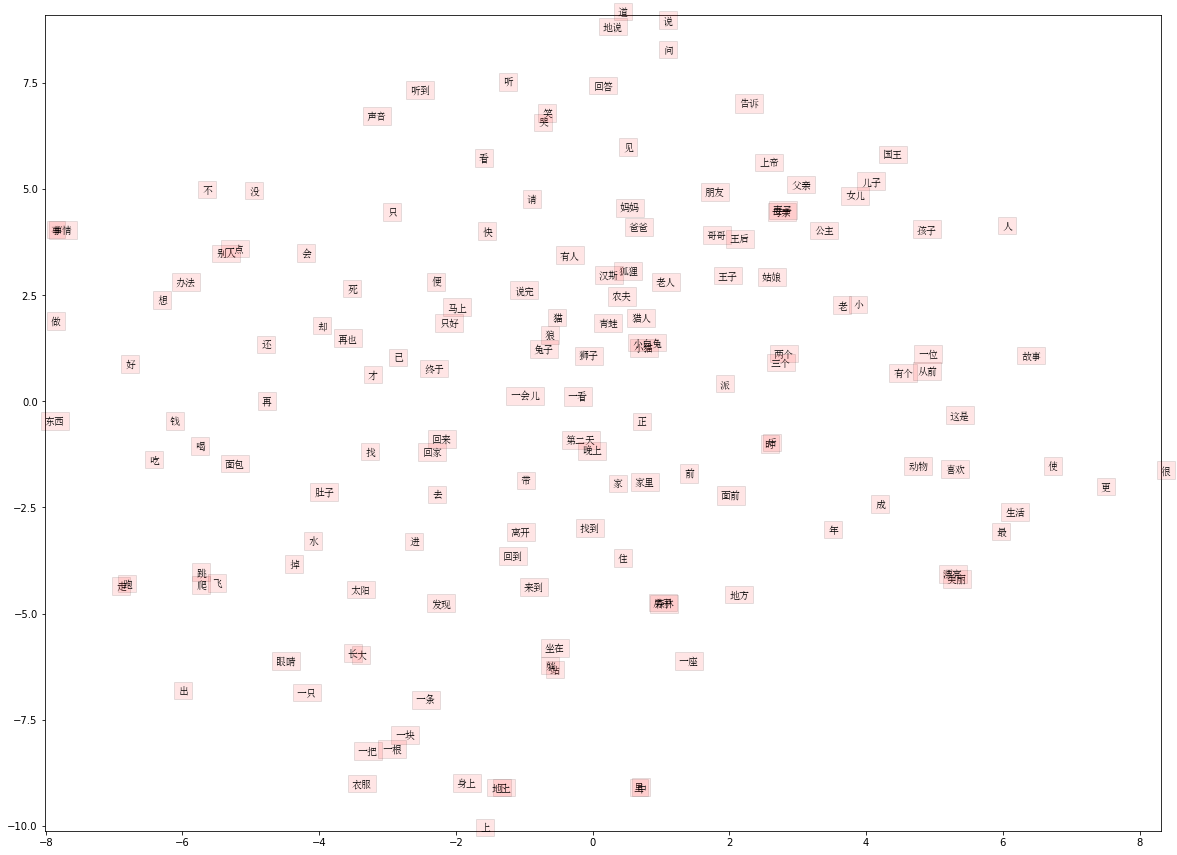

In [26]:
words = []
for i in range(0, 150):
    words.append(freq_word[i][0])
model = word2vec.Word2Vec.load('word_models/tonghua15_50.model')
visulalizeWord2Vec(model, words, 'tonghua15_50')

In [27]:
model = word2vec.Word2Vec(wordLists, min_count=1, size=100)
model.save('word_models/tonghua15_100.model')
# visulalizeWord2Vec(model, words, 'tonghua15_100')

In [28]:
model = word2vec.Word2Vec(wordLists, min_count=1, size=25)
model.save('word_models/tonghua15_25.model')
# visulalizeWord2Vec(model, words, 'tonghua15_25')